In [1]:
import os 

import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.chdir("../../")

In [2]:
IMAGE_DIR  = "data/nih/images-small/"
LABELS = ['Cardiomegaly', 
        'Emphysema', 
        'Effusion', 
        'Hernia', 
        'Infiltration', 
        'Mass', 
        'Nodule', 
        'Atelectasis',
        'Pneumothorax',
        'Pleural_Thickening', 
        'Pneumonia', 
        'Fibrosis', 
        'Edema', 
        'Consolidation']
train_df = pd.read_csv("data/nih/train-small.csv")
valid_df = pd.read_csv("data/nih/valid-small.csv")
test_df =  pd.read_csv("data/nih/test-small.csv")

With our dataset splits ready, we can now proceed with setting up our model to consume them. 
- For this we will use the off-the-shelf [ImageDataGenerator](https://keras.io/preprocessing/image/) class from the Keras framework, which allows us to build a "generator" for images specified in a dataframe. 
- This class also provides support for basic data augmentation such as random horizontal flipping of images.
- We also use the generator to transform the values in each batch so that their mean is $0$ and their standard deviation is 1. 
    - This will facilitate model training by standardizing the input distribution. 
- The generator also converts our single channel X-ray images (gray-scale) to a three-channel format by repeating the values in the image across all channels.
    - We will want this because the pre-trained model that we'll use requires three-channel inputs.

Since it is mainly a matter of reading and understanding Keras documentation, we have implemented the generator for you. There are a few things to note: 
1. We normalize the mean and standard deviation of the data
3. We shuffle the input after each epoch.
4. We set the image size to be 320px by 320px

In [3]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

#### Build a separate generator for valid and test sets

Now we need to build a new generator for validation and testing data. 

**Why can't we use the same generator as for the training data?**

Look back at the generator we wrote for the training data. 
- It normalizes each image **per batch**, meaning that it uses batch statistics. 
- We should not do this with the test and validation data, since in a real life scenario we don't process incoming images a batch at a time (we process one image at a time). 
- Knowing the average per batch of test data would effectively give our model an advantage.  
    - The model should not have any information about the test data.

What we need to do is normalize incoming test data using the statistics **computed from the training set**. 
* We implement this in the function below. 
* There is one technical note. Ideally, we would want to compute our sample mean and standard deviation using the entire training set. 
* However, since this is extremely large, that would be very time consuming. 
* In the interest of time, we'll take a random sample of the dataset and calcualte the sample mean and sample standard deviation.

In [4]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image", 
        y_col=LABELS, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [5]:

train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", LABELS)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", LABELS)

getting train generator...
Found 1000 validated image filenames.
getting train and valid generators...
Found 1000 validated image filenames.
Found 1 validated image filenames.
Found 420 validated image filenames.


e:\medsoft\Learning\ai_in_medicine\env\lib\site-packages\keras\preprocessing\image.py:1137: UserWarning: Found 108 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


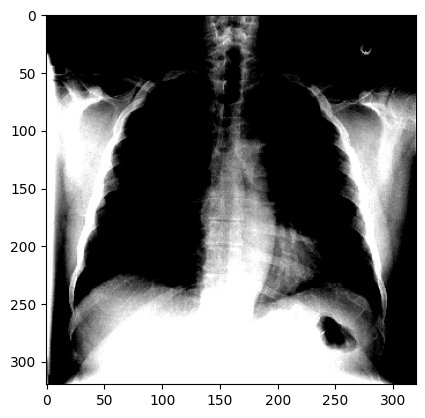

In [6]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0])